Data Preprocess
==========================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import copy
import os
from collections import OrderedDict
from sklearn import preprocessing
from sklearn import linear_model,svm,neighbors,ensemble
from sklearn import preprocessing, model_selection
from sklearn import metrics
from sklearn import mixture,cluster,manifold,decomposition,discriminant_analysis
%matplotlib inline

1. Load Data
----------------------

In [2]:
apath='E:/Data/zillow'

In [3]:
train16=pd.read_csv(apath+'/bak/train_2016_v2.csv')

In [4]:
properties16=pd.read_csv(apath+'/bak/properties_2016.csv',low_memory=False)

In [5]:
train17=pd.read_csv(apath+'/bak/train_2017.csv')

In [6]:
properties17=pd.read_csv(apath+'/bak/properties_2017.csv',low_memory=False)

In [7]:
train=pd.concat([train16,train17],ignore_index=True)

In [8]:
properties=properties16

In [9]:
properties.update(properties17)

In [10]:
properties_raw=properties.copy()

In [11]:
train.to_csv(apath+'/train.csv',index=False)

In [12]:
properties.to_csv(apath+'/prop_original.csv',index=False)

In [13]:
properties_control=properties.copy().fillna(properties.median())
properties_control=properties_control.drop(['propertyzoningdesc','propertycountylandusecode', 'fireplacecnt', 'fireplaceflag'], axis=1)
for c in properties_control.dtypes[properties_control.dtypes == object].index.values:
    properties_control[c] = (properties_control[c] == True)

In [14]:
for c, dtype in zip(properties_control.columns, properties_control.dtypes):
    if dtype == np.float64:
        properties_control[c] = properties_control[c].astype(np.float32)

In [15]:
del train16,train17,properties16,properties17

2. Prepare
--------------------------

### Global Config

In [16]:
upper_logerror=0.419
lower_logerror=-0.4
cat_map_top_percent=0.95
seg_map_n_seg=3

In [17]:
preprocess_pipeline=OrderedDict()

### Merge DataSets

In [18]:
train_properties=pd.merge(train,properties,on='parcelid')

#### Before Clean

In [19]:
shape=train_properties.shape
print('Raw TrainSet')
print('Total:'+str(shape[0])+'   Features:'+str(shape[1]-2))

Raw TrainSet
Total:167888   Features:58


#### After Clean

In [20]:
train_properties_clean=train_properties[(train_properties.logerror>=lower_logerror) & (train_properties.logerror<=upper_logerror)]
shape=train_properties_clean.shape
print('Cleaned TrainSet')
print('Total:'+str(shape[0])+'   Features:'+str(shape[1]-2))

Cleaned TrainSet
Total:164477   Features:58


3. Preprocess Function
-----------------------------------

In [21]:
def watch(prpty,fname,plot=True):
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    print(fname)
    fvc=feature.value_counts(dropna=False)
    fvcdpna=feature.value_counts(dropna=True)
    tfvc=train_feature.value_counts(dropna=False)
    tfvcdpna=train_feature.value_counts(dropna=True)
    strs1='Full NaN : %.2f%%:'%(float(feature.isnull().sum()*100)/float(len(properties)))
    strs1+='   '+'Full NumOfCat : %d'%(len(fvc))
    strs1+='   '+'Full CatRatio : %.2f%%'%(float(len(fvcdpna)*100)/float(len(feature[feature.notnull()])))
    strs2='Train NaN : %.2f%%'%(float(train_feature.isnull().sum()*100)/float(len(train_properties)))
    strs2+='   '+'Train NumOfCat : %d'%(len(tfvc))
    strs2+='   '+'Train CatRatio : %.2f%%'%(float(len(tfvcdpna)*100)/float(len(train_feature[feature.notnull()])))
    print(strs1)
    print(strs2)
    print(str(fvcdpna.tolist()[:10]))
    if len(fvcdpna.value_counts())>1:
        if plot:
            plt.figure(figsize=(15,3))
            plt.subplot(121)
            sns.distplot(fvcdpna,kde=False)
            plt.subplot(122)
            sns.distplot(feature[feature.notnull()],hist=False)

In [22]:
def cat_process(prpty,fname,top_percent=cat_map_top_percent,rank_by_properties=True,custom=None):
    # automatically asign 'N' to NaN, other letters to categories and group remaining categories into class 'R'
    # N for NaN  R for Rare 
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    charlist=['A','B','C','D','E','F','G','H','I','J','K','L','M','O','P','Q','S','T','U','V','W','X','Y','Z']
    if custom is not None:
        def custom_func(x):
            if not isinstance(x,str):
                if not np.isnan(x):
                    return custom(x)
                else:
                    return x
            else:
                return custom(x)
        feature=feature.apply(custom_func)
        train_feature=train_feature.apply(custom_func)
    else:
        custom_func=None
    feature_counts=feature.value_counts(dropna=True)
    train_feature_counts=train_feature.value_counts(dropna=True)
    map_func={'N':'N'}
    rank=feature_counts.tolist()
    if not rank_by_properties:rank=train_feature_counts
    for i,n in enumerate(rank):
        if top_percent==0:break
        map_func[feature_counts.index[i]]=charlist[i]
        if float(sum(rank[:i+1]))/(sum(rank))>top_percent:break
    print(map_func)
    feature=feature.fillna('N')
    train_feature=train_feature.fillna('N')
    feature=feature.map(map_func)
    train_feature=train_feature.map(map_func)
    feature=feature.fillna('R')
    train_feature=train_feature.fillna('R')
    def foo(column):
        col=column.copy()
        if custom_func is not None:
            col=col.apply(custom_func)
        col=col.fillna('N')
        col=col.map(map_func)
        col=col.fillna('R')
        return col
    preprocess_pipeline[fname]=foo
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Property Adjust')
    feature_counts=feature.value_counts(dropna=False)
    (feature_counts/len(feature)).plot(kind='bar',x='Cataglories',y='%')
    for i,v in enumerate(feature_counts):
        plt.text(i,float(v)/len(feature),v,ha='center',va='bottom',color='orange')
    plt.subplot(122)
    plt.title('Train Adjust')
    train_feature_counts=train_feature.value_counts(dropna=False)
    (train_feature_counts/len(train_feature)).plot(kind='bar',logy=True,x='Cataglories',y='Log%')
    for i,v in enumerate(train_feature_counts):
        plt.text(i,float(v)/len(train_feature),v,ha='center',va='bottom',color='orange')

In [23]:
def num_process(prpty,fname,scaling=False,log=False,norm=False,custom=None):
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    feature=feature[feature.notnull()]
    train_feature=train_feature[train_feature.notnull()]
    plt.figure(figsize=(15,6))
    if custom is None:
        def fn(x):
            if scaling:
                x=(x-min(x))/(max(x)-min(x))
            if log:
                x=np.log(x+1)
            if norm:
                x = preprocessing.normalize(x.values.reshape(1,-1), norm='l2')
                x=x[0]
            return x
    else:
        fn=custom
    feature=fn(feature)
    train_feature=fn(train_feature)
    preprocess_pipeline[fname]=fn
    plt.subplot(121)
    plt.title('Property Adjust')
    sns.distplot(feature)
    plt.subplot(122)
    plt.title('Train Adjust')
    sns.distplot(train_feature)

In [24]:
def seg_process(prpty,fname,n_seg=seg_map_n_seg,top_percent=cat_map_top_percent,scaling=False,log=False,norm=False,rank_by_properties=True,custom=None):
    feature=prpty[fname].copy()
    train_feature=pd.merge(train,prpty,on='parcelid')[fname].copy()
    charlist=['A','B','C','D','E','F','G','H','I','J','K','L','M','O','P','Q','S','T','U','V','W','X','Y','Z']
    if custom is None:
        def fn(x):
            if scaling:
                x=(x-min(x))/(max(x)-min(x))
            if log:
                x=np.log(x+1)
            if norm:
                x = preprocessing.normalize(x.values.reshape(1,-1), norm='l2')
                x=x[0]
            return x
    else:
        fn=custom
    feature=fn(feature[feature.notnull()])
    train_feature=fn(train_feature[train_feature.notnull()])
    
    
    ft=feature.copy()
    if not rank_by_properties:ft=train_feature.copy()
    mean=ft.mean()
    rad=(max(ft)-min(ft))/2
    drad=rad
    ratio=1.
    eps=1e-4
    i=0
    while ratio<top_percent-eps or ratio>top_percent+eps:
        if ratio<top_percent-eps:
            drad+=drad/2
        else:
            drad/=2
        ratio=float(len(ft[(ft>=mean-drad) & (ft<=mean+drad)]))/float(len(ft))
        i+=1
        if i>10000:
            print 'Time Out'
            break
    print('Values Which In Range Has A Ratio : %.2f%%'%(ratio*100))
    print('Values large than {} and less than {} will be map to RL RG'.format(mean-drad,mean+drad))
    
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Property Adjust Before Segment')
    plt.plot([mean-drad,mean-drad],[0,1],c='r')
    plt.plot([mean+drad,mean+drad],[0,1],c='r')
    for i in range(1,n_seg):
        plt.plot([mean-drad+i*((drad*2)/n_seg),mean-drad+i*((drad*2)/n_seg)],[0,1],c='y')
    sns.distplot(feature)
    plt.subplot(122)
    plt.title('Train Adjust Before Segment')
    plt.plot([mean-drad,mean-drad],[0,1],c='r')
    plt.plot([mean+drad,mean+drad],[0,1],c='r')
    for i in range(1,n_seg):
        plt.plot([mean-drad+i*((drad*2)/n_seg),mean-drad+i*((drad*2)/n_seg)],[0,1],c='y')
    sns.distplot(train_feature)
    
    def f(x):
        x=fn(x)
        x=x.fillna('N')
        def s(n):
            if n=='N':
                return n
            if n>=mean-drad and n<=mean+drad:
                return charlist[int((n-mean+drad)/((drad*2)/n_seg))]
            else:
                if n<mean-drad:
                    return 'RL'
                else:
                    return 'RG'
        x=x.apply(s)
        return x
    
    feature=f(prpty[fname].copy())
    if fname in train.columns:
        train_feature=f(train[fname].copy())
    else:
        train_feature=feature

    preprocess_pipeline[fname]=f
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.title('Property Adjust After Segment')
    feature_counts=feature.value_counts(dropna=False)
    (feature_counts/len(feature)).plot(kind='bar',x='Cataglories',y='%')
    for i,v in enumerate(feature_counts):
        plt.text(i,float(v)/len(feature),v,ha='center',va='bottom',color='orange')
    plt.subplot(122)
    plt.title('Train Adjust After Segment')
    train_feature_counts=train_feature.value_counts(dropna=False)
    (train_feature_counts/len(train_feature)).plot(kind='bar',logy=True,x='Cataglories',y='Log%')
    for i,v in enumerate(train_feature_counts):
        plt.text(i,float(v)/len(train_feature),v,ha='center',va='bottom',color='orange')

In [25]:
def clustering(model,x,name):
    try:
        model.fit(x)
        properties[name]=model.predict(x)
    except KeyboardInterrupt:
        print('Interrupted')

In [42]:
def savecsv(name,prpty,cat=(),num=(),lognum=()):
    if not os.path.isdir(apath+'/sets'):
        os.mkdir(apath+'/sets')
    if not os.path.isdir(apath+'/sets/'+name):
        os.mkdir(apath+'/sets/'+name)
    prpty=prpty.copy()
    parcelid=prpty.parcelid.copy()
    prpty=prpty.fillna(prpty.median())
    bi=prpty.dtypes[prpty.dtypes == object].index.values.tolist()
    rm=prpty.columns.copy().values.tolist()
    for c in bi+cat+num:
        if c in rm:
            rm.remove(c)
    for c in bi:
        prpty[c] = (prpty[c] == True)
    for c, dtype in zip(prpty.columns, prpty.dtypes):
        if dtype == np.float64:
            prpty[c] = prpty[c].astype('float32')
    for c in cat:
        prpty[c]=preprocessing.LabelEncoder().fit_transform(prpty[c])
    prpty.to_csv(apath+'/sets/'+name+'/tree.csv',index=False)
    for c in lognum:
        prpty[c]=np.log(1+prpty[c])
    prpty[num]=preprocessing.StandardScaler().fit_transform(prpty[num])
    if len(cat)>0:
        dmcat=pd.get_dummies(prpty[cat], columns=cat, drop_first=False).astype('float32')*2-1
        prpty=pd.concat([dmcat,prpty[num],prpty[bi].astype('float32')*2-1,prpty[rm]],axis=1)
    else:
        prpty=pd.concat([prpty[num],prpty[bi].astype('float32')*2-1,prpty[rm]],axis=1)
    prpty['parcelid']=parcelid
    prpty.to_csv(apath+'/sets/'+name+'/linear.csv',index=False)
    del prpty

4. Feature Classification
---------------------------

In [28]:
features2impute_mode=['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fips', 'fullbathcnt', 'propertycountylandusecode', 'propertylandusetypeid','rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt', 'assessmentyear', 'censustractandblock']
features2impute_median=['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude', 'longitude', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet']
features2impute_ml=['buildingqualitytypeid', 'heatingorsystemtypeid', 'unitcnt']
category_features=['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'regionidcounty', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag']
numerical_features=['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'unitcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
segment_features=['basementsqft', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'poolsizesum', 'yardbuildingsqft17', 'yardbuildingsqft26']
special=['latitude', 'longitude', 'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidneighborhood', 'regionidzip', 'yearbuilt', 'assessmentyear', 'taxdelinquencyyear', 'censustractandblock']

In [ ]:
savecsv('control',properties_control,cat=[],num=numerical_features+['latitude', 'longitude'])
del properties_control

In [35]:
for f in features2impute_median:
    properties[f]=properties[f].fillna(properties[f].median())

In [36]:
for f in features2impute_mode:
    properties[f]=properties[f].fillna(properties[f].mode().tolist()[0])

6. Special Features
-------------------------------------

In [37]:
special_num=['latitude', 'longitude','yearbuilt', 'assessmentyear']
special_cat=['propertyzoningdesc','propertycountylandusecode','regionidneighborhood','regionidcity', 'regionidzip','rawcensustractandblock','censustractandblock', 'taxdelinquencyyear']

{'LARS': 'F', 'LBR': 'E', 'LCR': 'B', 'SCUR': 'H', 'LARD': 'C', 'N': 'N', 'LARE': 'G', 'LCA': 'D', 'LAR': 'A'}
{'C': 'B', 'E': 'D', 'D': 'C', 'G': 'H', 'F': 'K', 'H': 'J', 'DC': 'F', 'N': 'N', 'P': 'E', 'V': 'G', 'HC': 'I', 'empty': 'A'}
{'55': 'H', '54': 'C', '53': 'D', '52': 'E', '61': 'B', '62': 'A', '64': 'F', '67': 'G', 'N': 'N'}
{'55': 'E', '54': 'C', '45': 'F', '51': 'A', '53': 'D', '52': 'B', '61': 'G', 'N': 'N'}
{'596': 'A', '597': 'B', 'N': 'N'}
{'590': 'A', 'N': 'N', '379': 'G', '110': 'F', '371': 'D', '373': 'I', '372': 'E', '375': 'B', '374': 'C', '376': 'H'}
{'60590': 'A', '61110': 'F', 'N': 'N', '60379': 'G', '60375': 'B', '60374': 'C', '60376': 'H', '60371': 'D', '60373': 'I', '60372': 'E'}


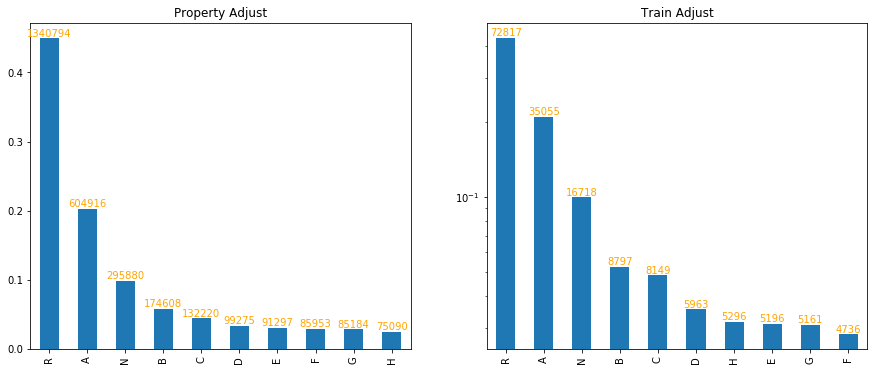

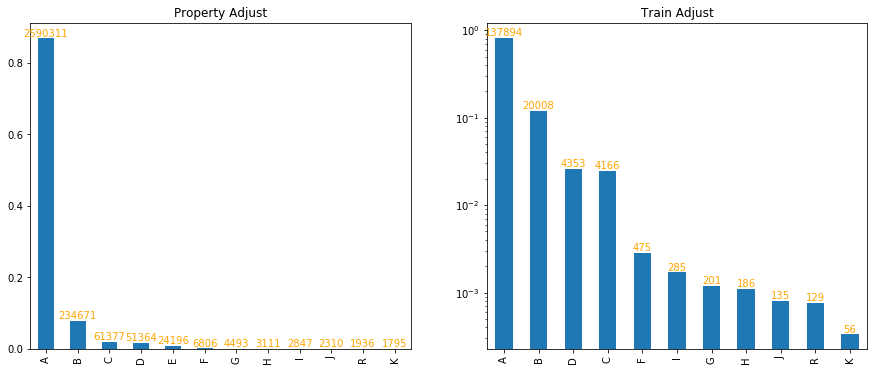

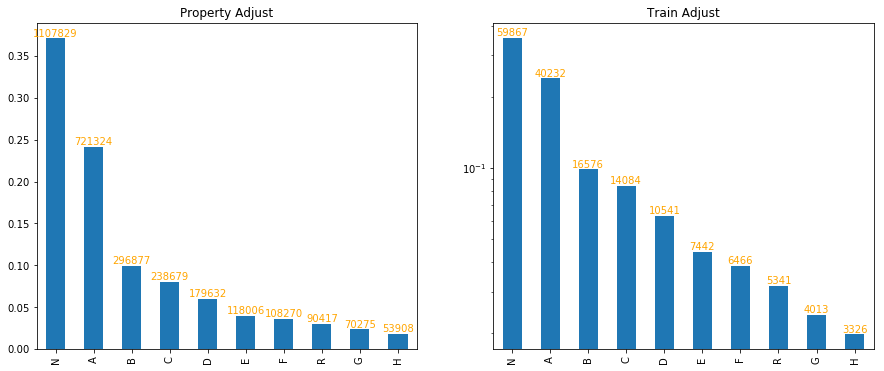

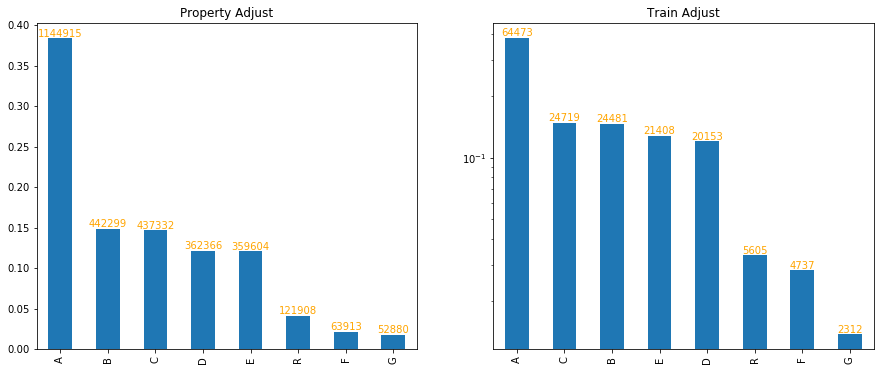

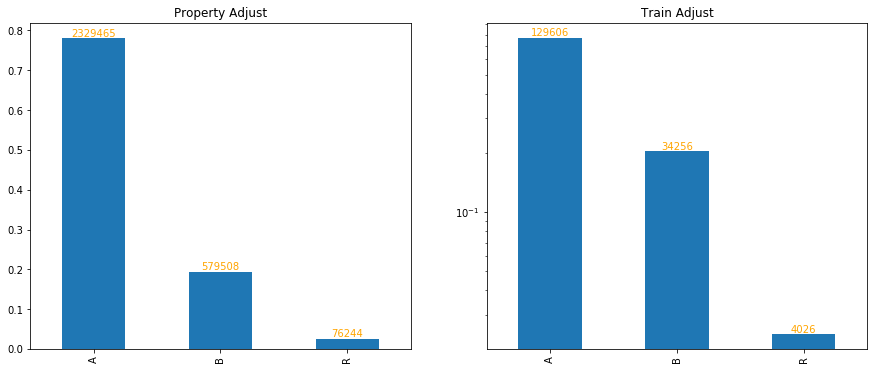

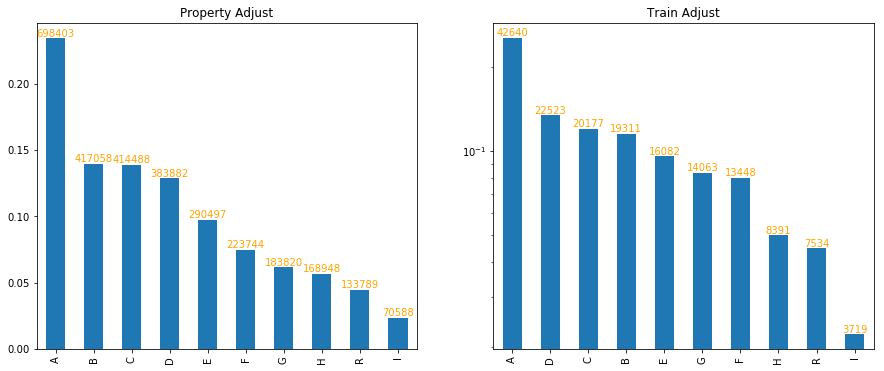

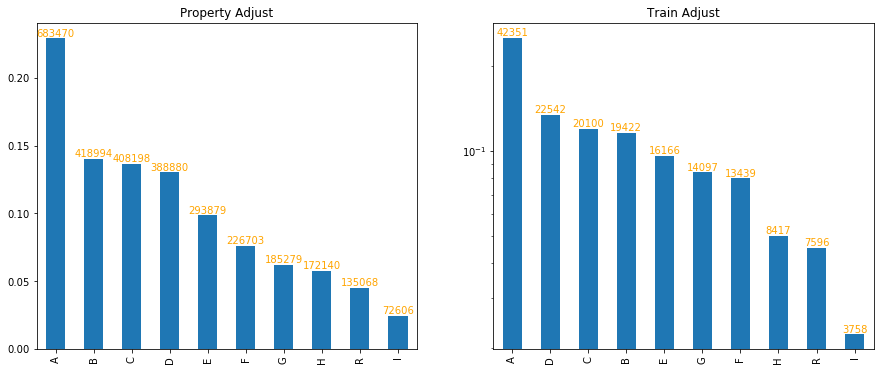

In [38]:
f='propertyzoningdesc'
def c(x):
    l=''
    x=str(x)
    for i in x:
        if i.isalpha():
            l=l+i
        else:
            break
    if l=='':
        l='empty'
    return l
cat_process(properties,f,top_percent=0.5,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

f='propertycountylandusecode'
def c(x):
    l=''
    x=str(x)
    for i in x:
        if i.isalpha():
            l=l+i
    if l=='':
        l='empty'
    return l
cat_process(properties,f,top_percent=0.999,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

f='regionidneighborhood'
def c(x):
    x=str(int(x))
    return str(len(x))+x[0]
cat_process(properties,f,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

f='regionidcity'
def c(x):
    x=str(int(x))
    return str(len(x))+x[0]
cat_process(properties,f,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

f='regionidzip'
def c(x):
    x=str(int(x))
    return str(len(str(x)))+str(x)[:2]
cat_process(properties,f,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

f='rawcensustractandblock'
def c(x):
    x=str(int(x))
    return str(x)[2:5]
cat_process(properties,f,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

f='censustractandblock'
def c(x):
    x=str(int(x))
    return str(x)[:5]
cat_process(properties,f,custom=c)
properties[f]=preprocess_pipeline[f](properties[f])

{10.0: 'F', 11.0: 'E', 12.0: 'D', 13.0: 'C', 14.0: 'B', 15.0: 'A', 'N': 'N'}


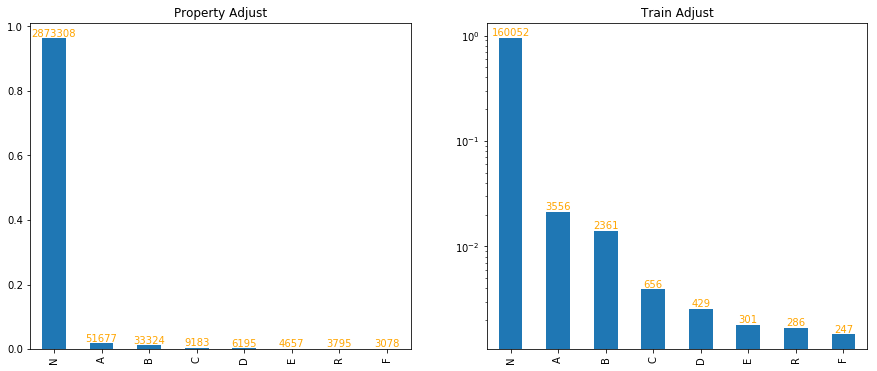

In [39]:
f='taxdelinquencyyear'
cat_process(properties,'taxdelinquencyyear')
properties[f]=preprocess_pipeline[f](properties[f])

In [40]:
f='yearbuilt'
properties[f]=2017-properties[f]
f='assessmentyear'
properties[f]=2017-properties[f]

In [43]:
savecsv('special',properties,cat=special_cat,num=numerical_features+special_num,lognum=numerical_features)

7. Categorical Feature
-------------------------------------

{1.0: 'A', 13.0: 'B', 'N': 'N'}
{8.0: 'B', 2.0: 'C', 7.0: 'A', 'N': 'N'}
{3.0: 'B', 4.0: 'A', 'N': 'N'}
{4.0: 'A', 5.0: 'E', 6.0: 'C', 7.0: 'B', 8.0: 'D', 9.0: 'F', 'N': 'N'}
{66.0: 'A', 'N': 'N'}
{6059.0: 'B', 6037.0: 'A', 6111.0: 'C', 'N': 'N'}
{True: 'A', 'N': 'N'}
{2.0: 'A', 7.0: 'B', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{261.0: 'A', 263.0: 'E', 266.0: 'B', 269.0: 'D', 'N': 'N', 246.0: 'C'}
{2061.0: 'C', 3101.0: 'A', 1286.0: 'B', 'N': 'N'}
{7.0: 'A', 'N': 'N'}
{1.0: 'A', 'N': 'N'}
{6.0: 'A', 'N': 'N'}
{1.0: 'A', 2.0: 'B', 'N': 'N'}
{True: 'A', 'N': 'N'}
{'Y': 'A', 'N': 'N'}


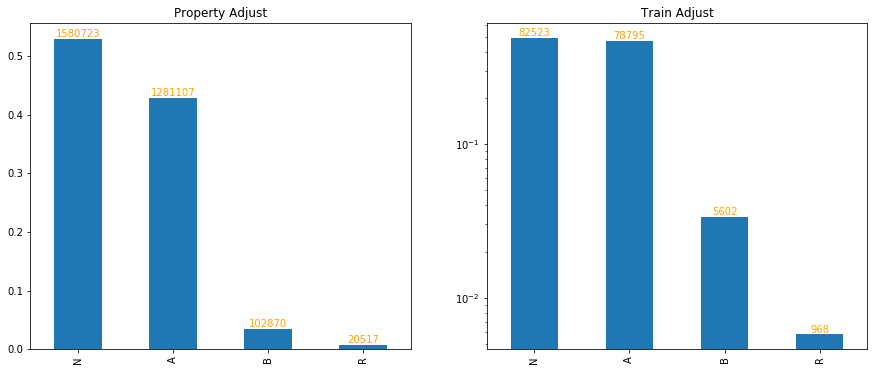

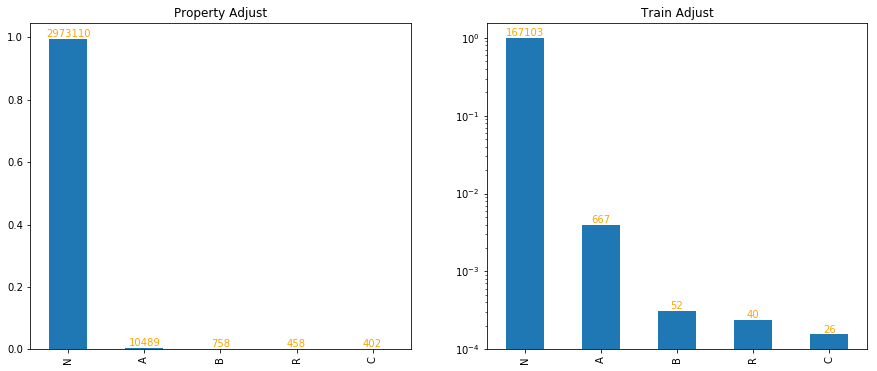

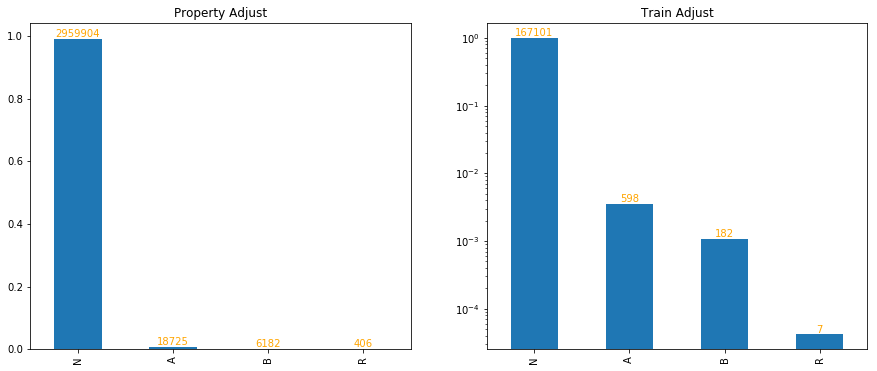

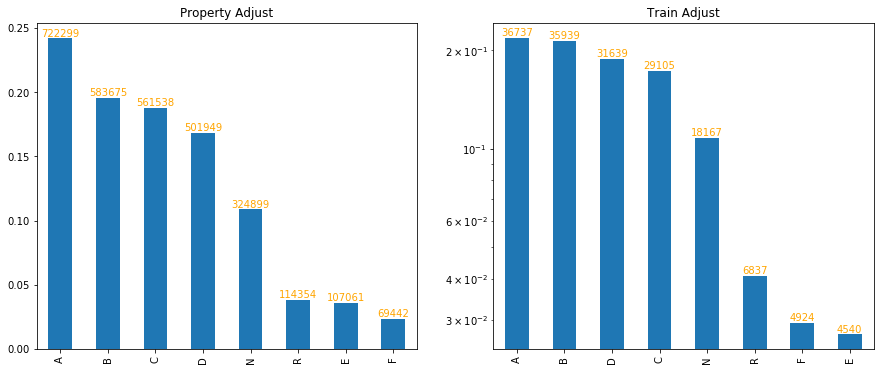

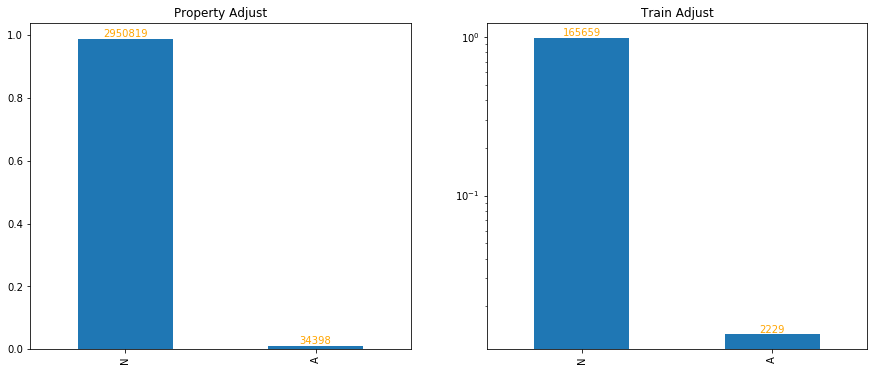

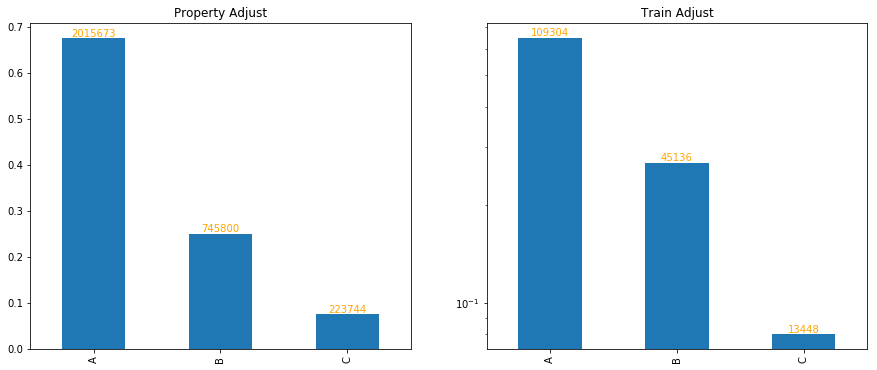

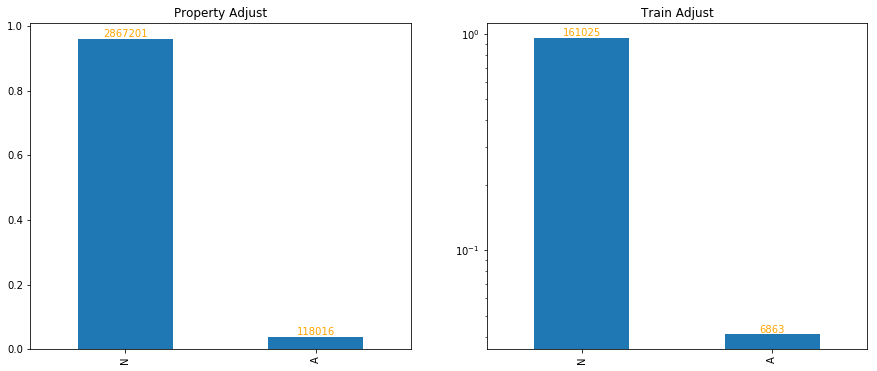

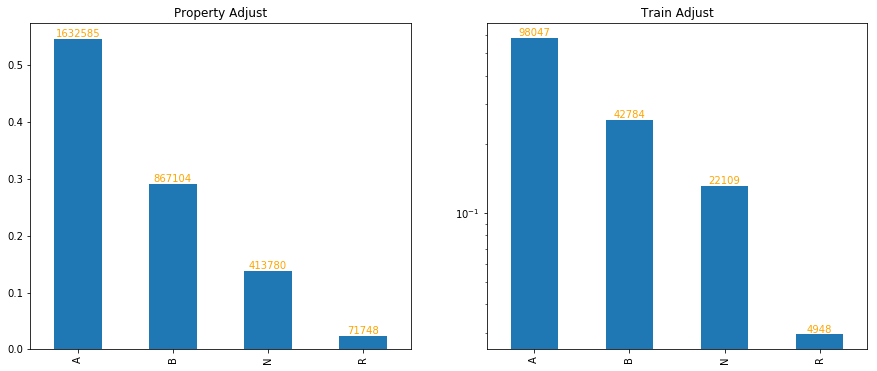

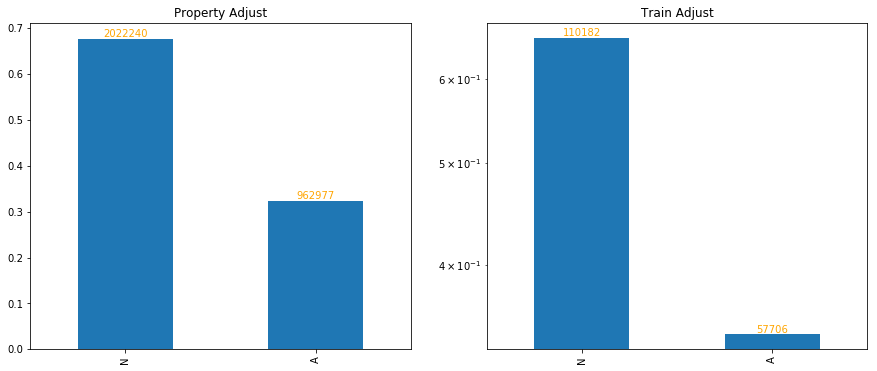

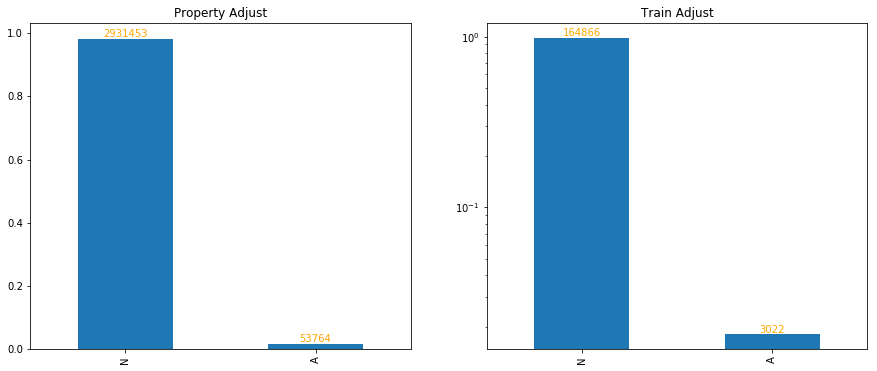

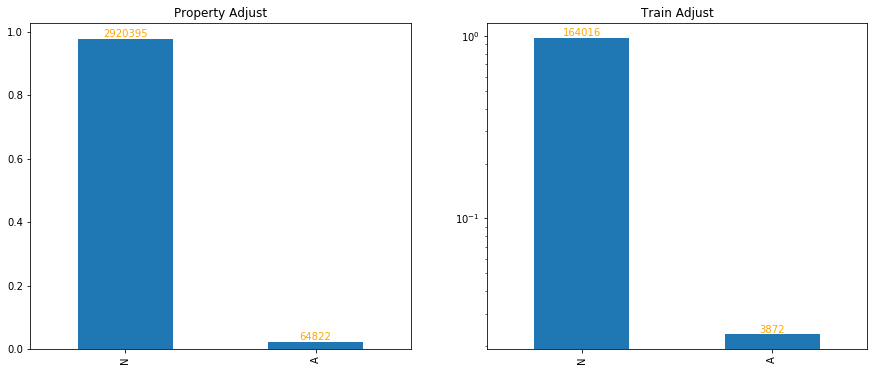

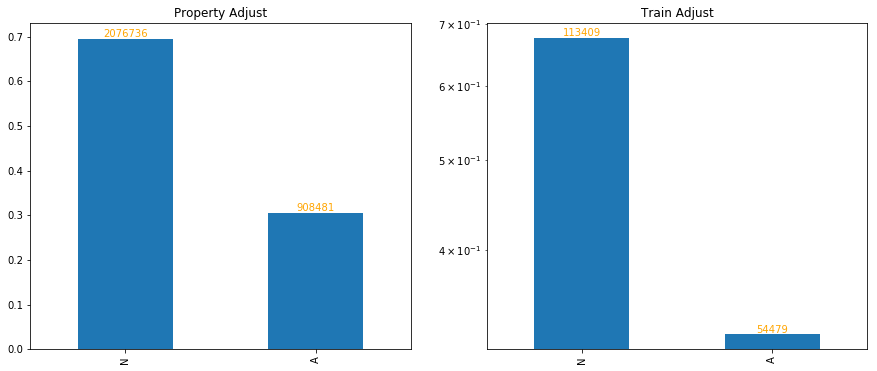

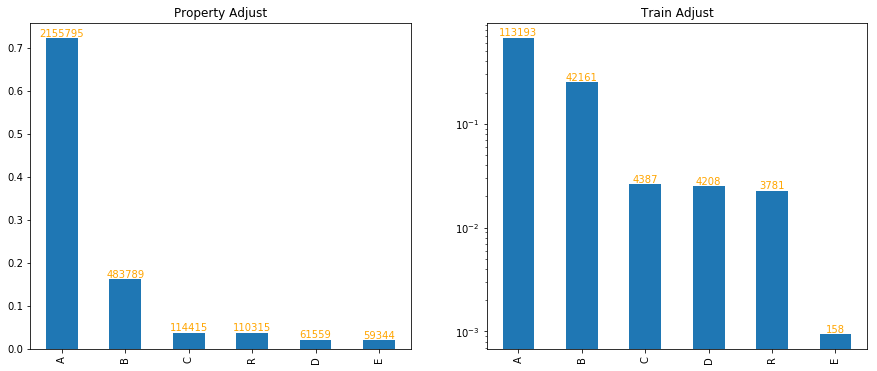

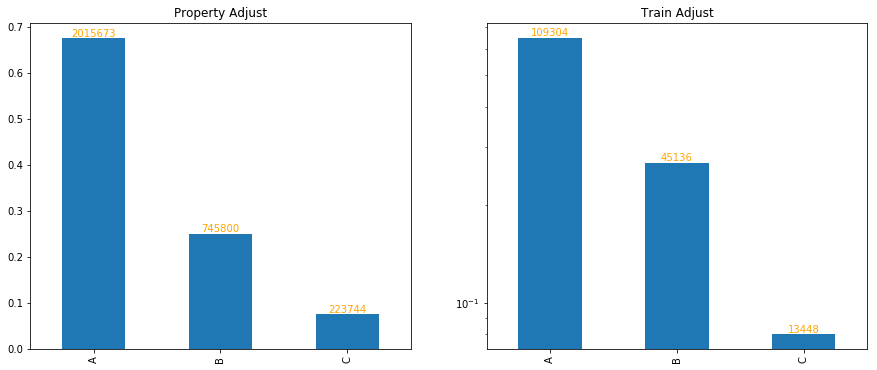

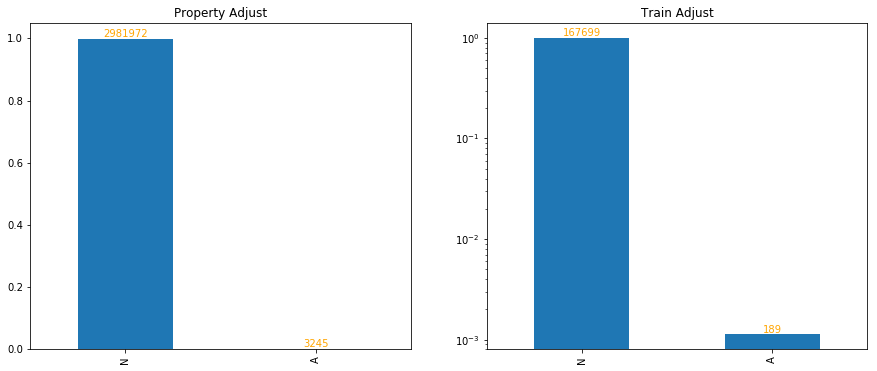

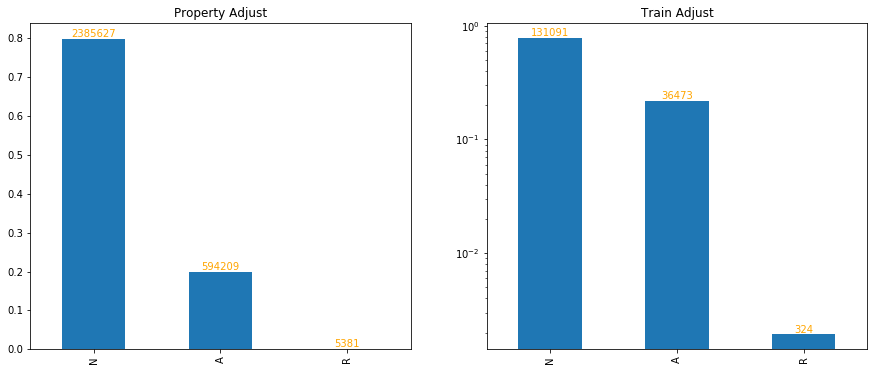

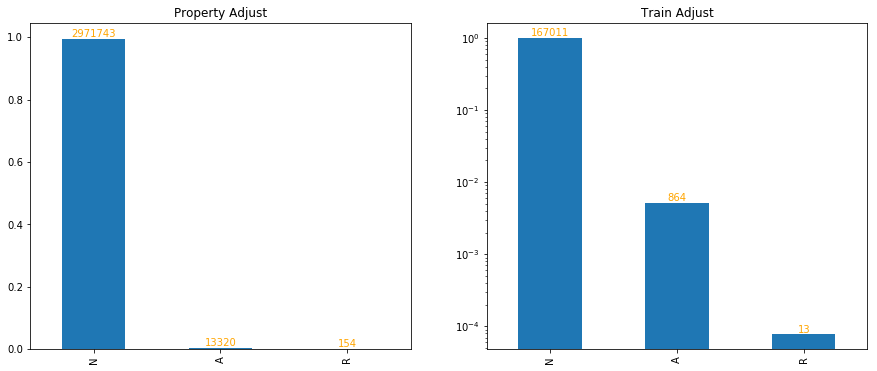

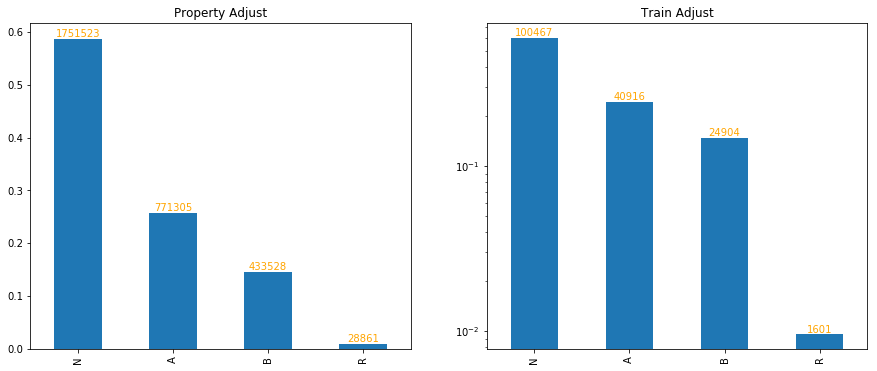

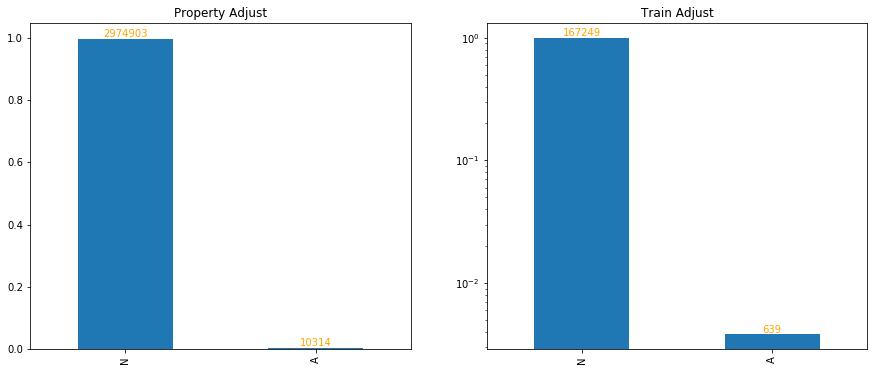

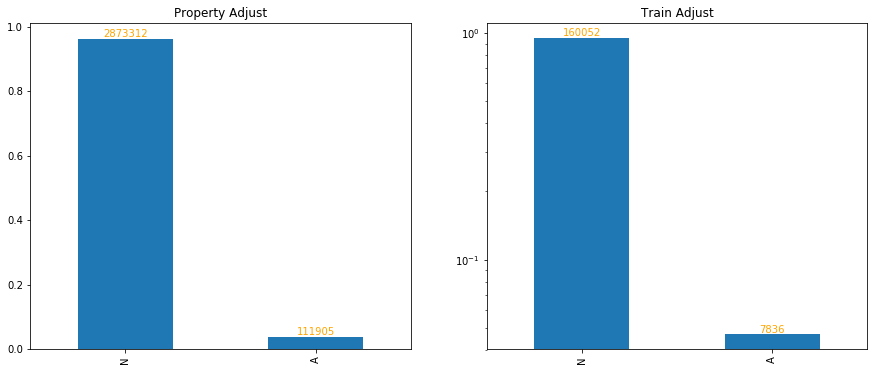

In [44]:
for f in category_features:
    cat_process(properties,f)

In [45]:
for f in category_features:
    if f not in features2impute_ml:
        properties[f]=preprocess_pipeline[f](properties[f])

8. Segment Feature
-------------------------------------

Time Out
Values Which In Range Has A Ratio : 80.23%
Values large than 5.07855399998 and less than 7.24398266904 will be map to RL RG
Values Which In Range Has A Ratio : 94.99%
Values large than 6.25922805578 and less than 8.01994749735 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 88.30%
Values large than 6.45247930955 and less than 7.57070621849 will be map to RL RG
Values Which In Range Has A Ratio : 94.99%
Values large than 6.91102549768 and less than 8.57619144796 will be map to RL RG
Values Which In Range Has A Ratio : 95.00%
Values large than 6.25005899247 and less than 8.03714162354 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 99.20%
Values large than 5.9209115197 and less than 9.16483425097 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 86.29%
Values large than 0.467167716875 and less than 1.04750920412 will be map to RL RG
Time Out
Values Which In Range Has A Ratio : 74.84%
Values large than 0.817619775827 and less th

C:\Users\aeloyq\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Time Out
Values Which In Range Has A Ratio : 76.29%
Values large than 4.01123649498 and less than 6.29194948825 will be map to RL RG


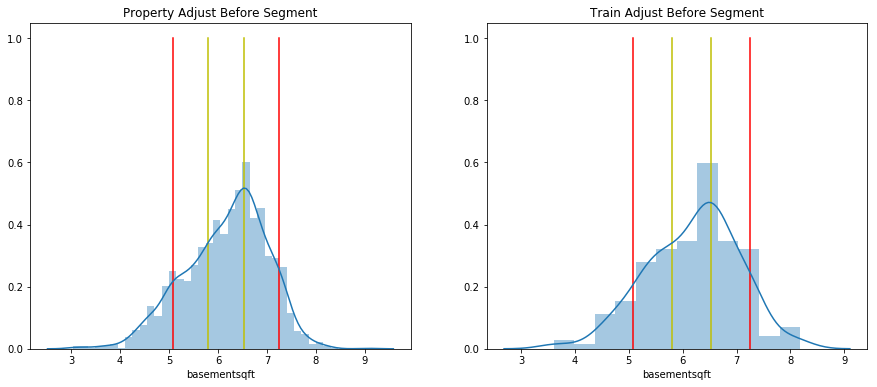

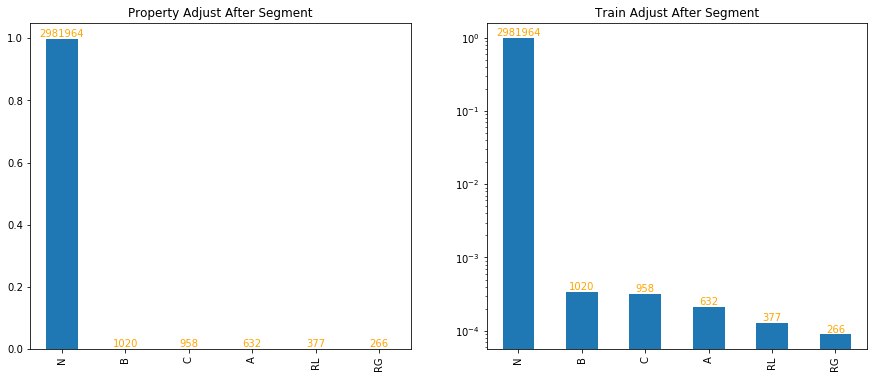

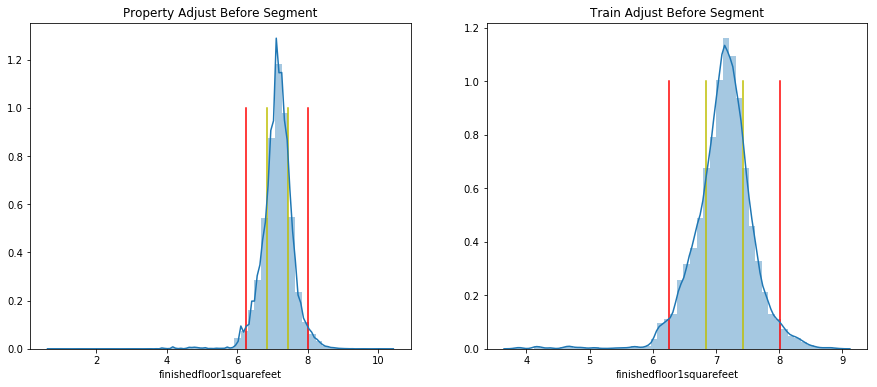

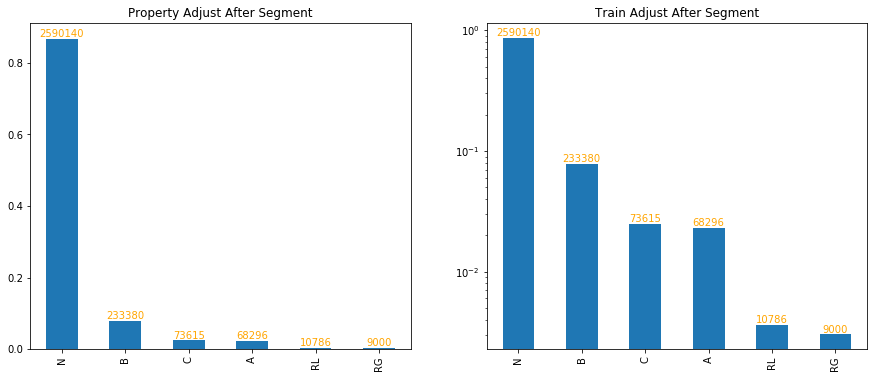

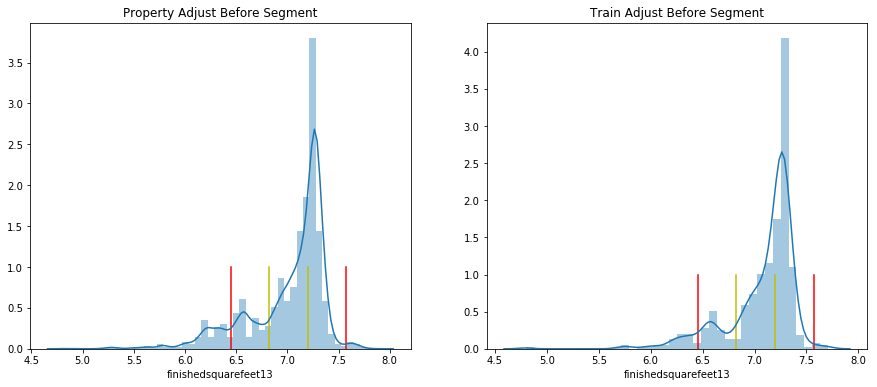

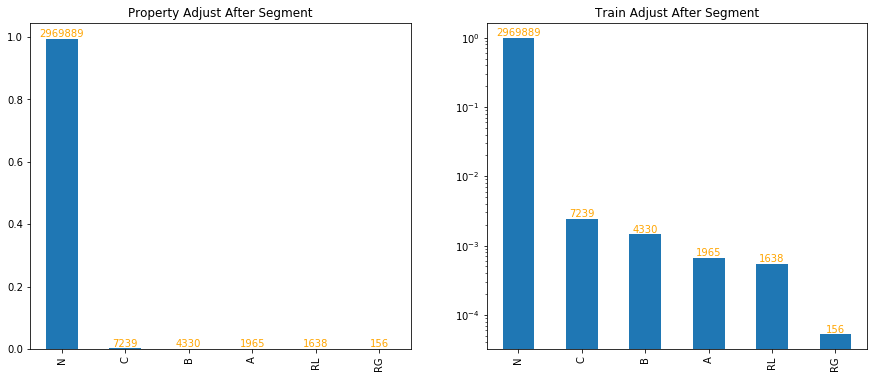

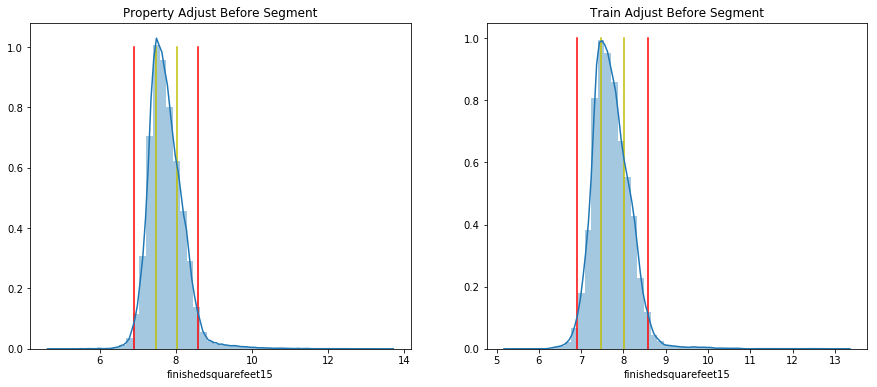

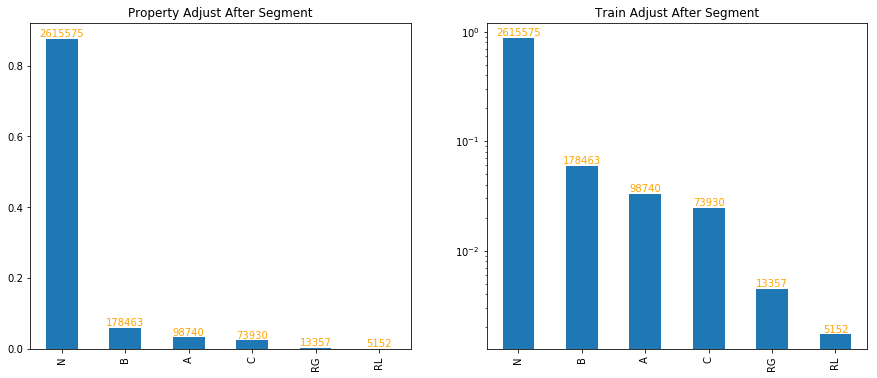

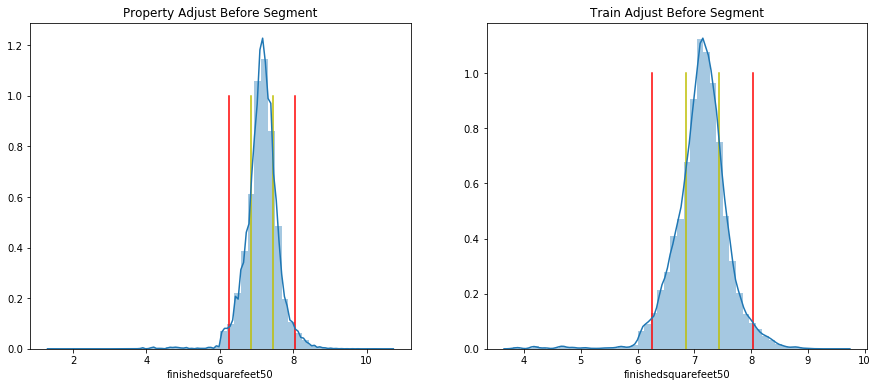

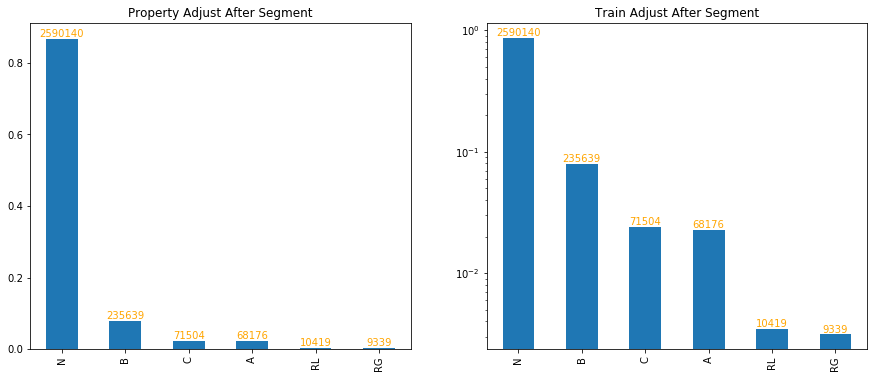

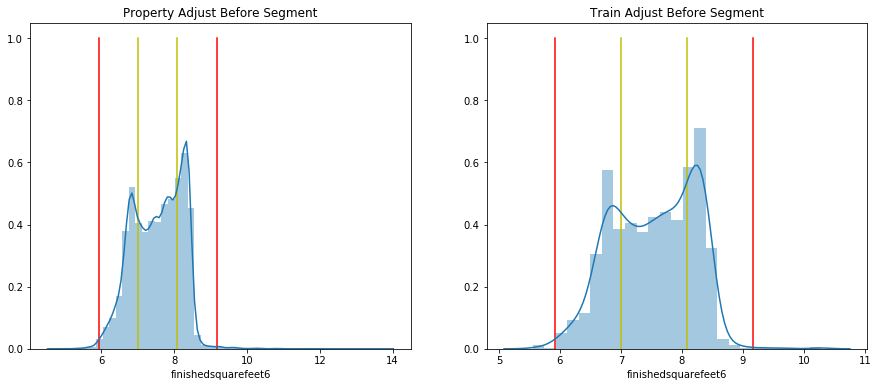

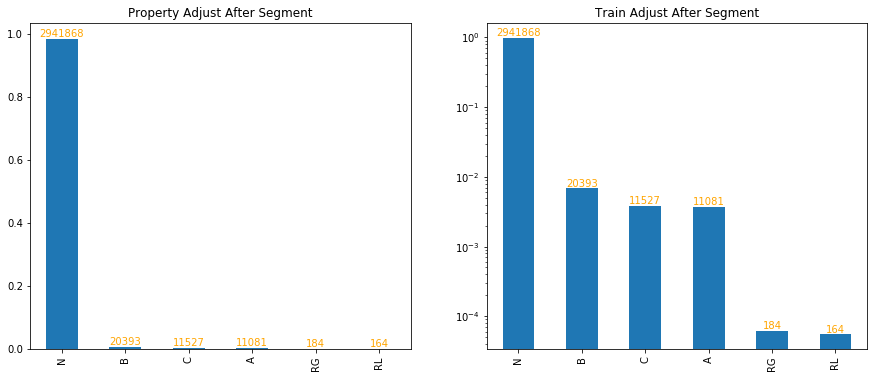

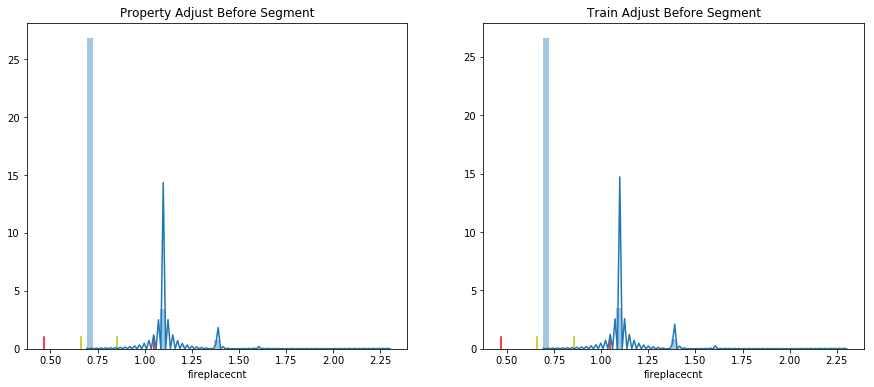

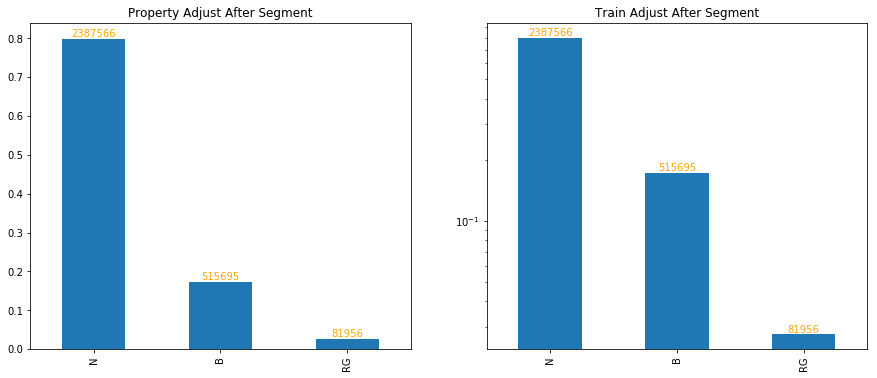

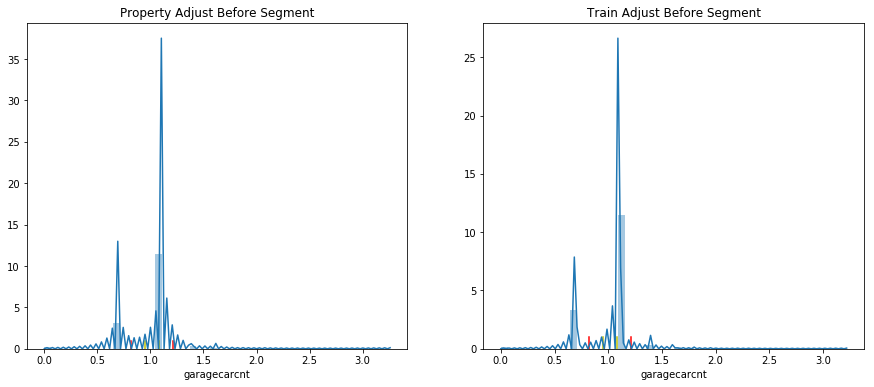

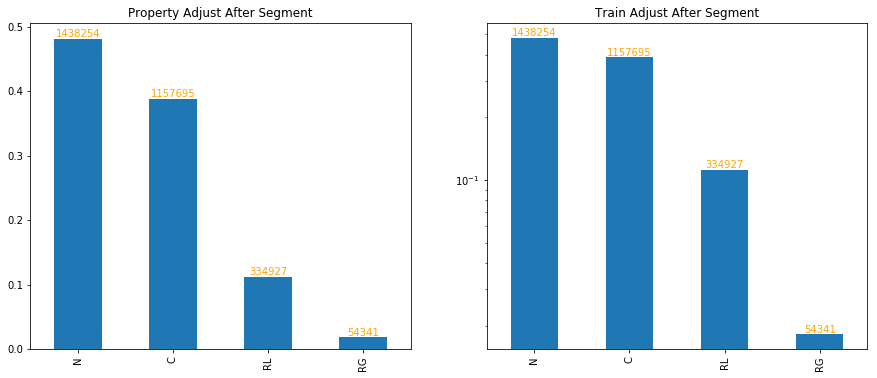

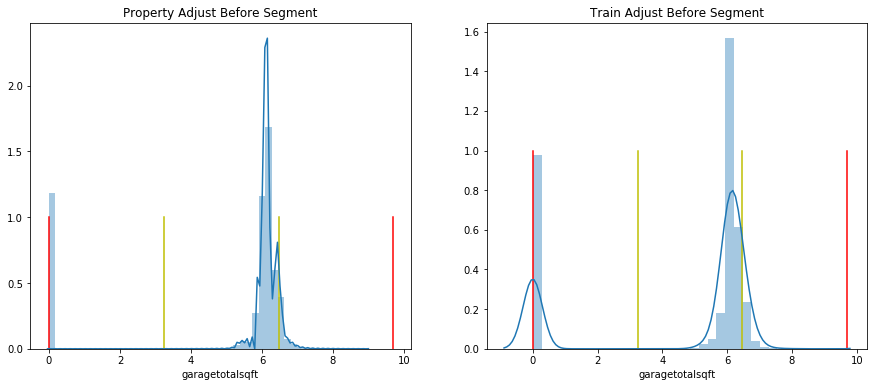

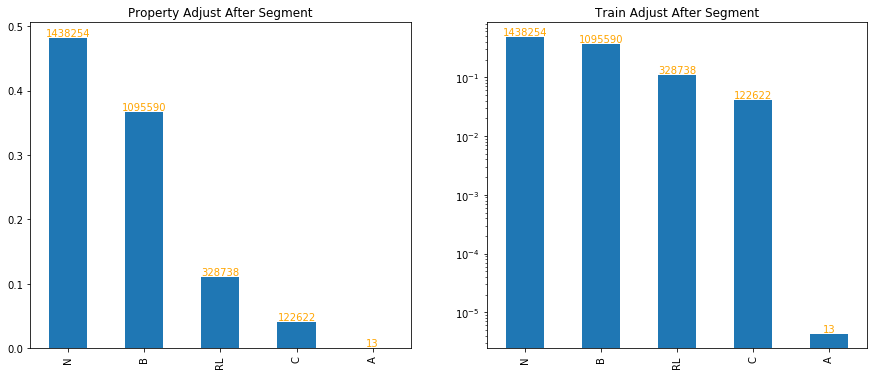

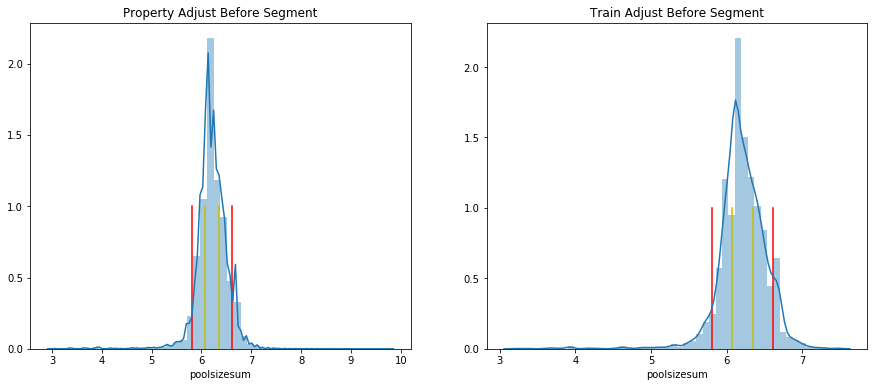

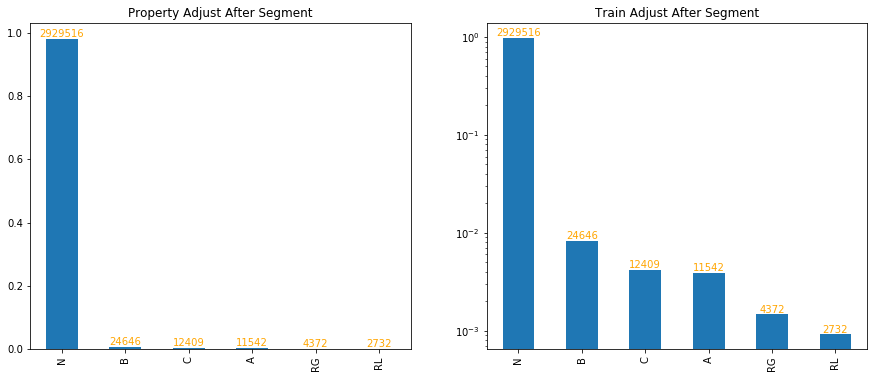

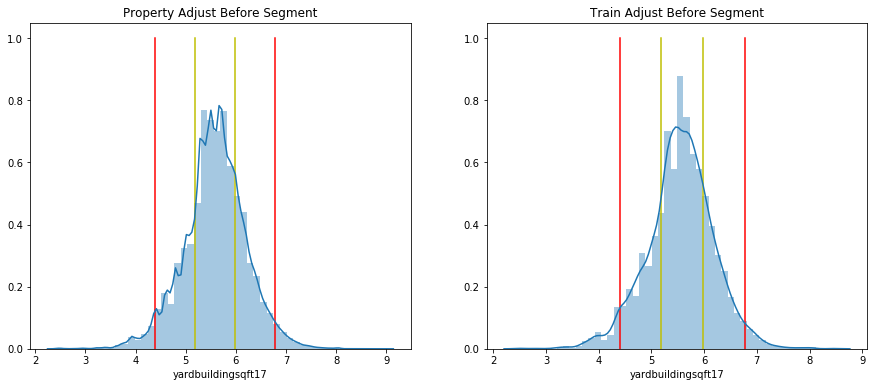

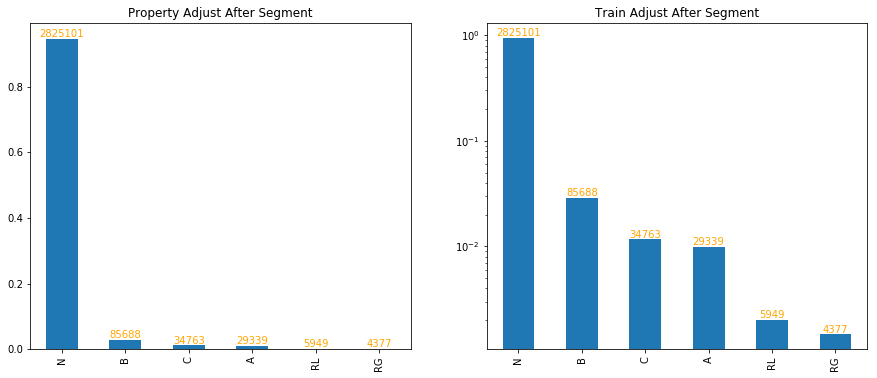

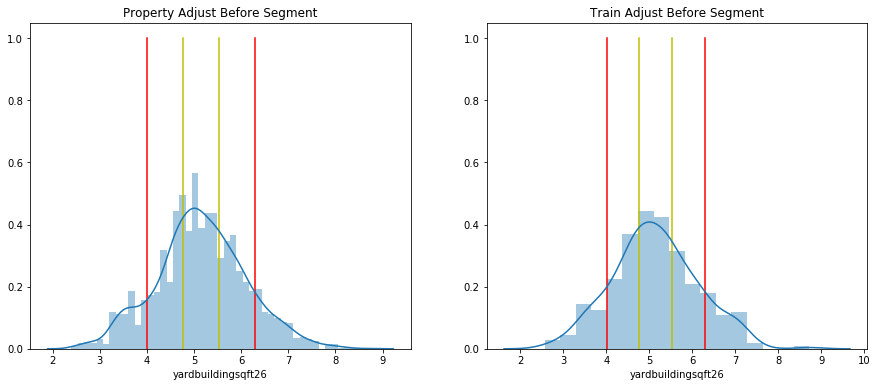

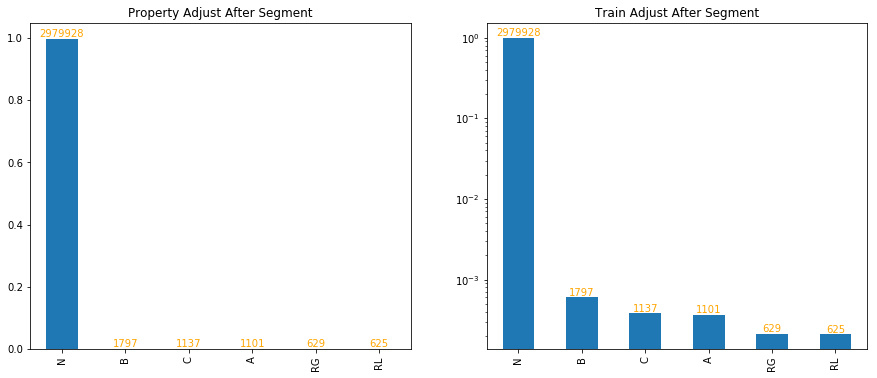

In [46]:
for f in segment_features:
    seg_process(properties,f,log=True)

In [47]:
for f in segment_features:
    if f not in features2impute_ml:
        properties[f]=preprocess_pipeline[f](properties[f])

In [48]:
savecsv('segment',properties,cat=category_features+segment_features+special_cat,num=numerical_features+special_num,lognum=numerical_features)

9. Create New Geo Features
-----------------------------

In [49]:
location_num=properties[['latitude', 'longitude']].copy()
location_cat=properties[['fips','propertyzoningdesc','propertycountylandusecode','regionidneighborhood','regionidcity', 'regionidzip','rawcensustractandblock','censustractandblock']].copy()

In [50]:
for c in location_cat:
    location_cat[c]=preprocessing.LabelEncoder().fit_transform(location_cat[c])
location_cat=preprocessing.OneHotEncoder().fit_transform(location_cat).toarray()
location_cat=location_cat*2-1
location_cat=location_cat.astype('int8')

In [51]:
location_num=preprocessing.StandardScaler().fit_transform(location_num).astype('float32')

In [52]:
location_x=np.concatenate([location_cat,location_num],1)
location_x=location_x.astype('float32')

In [53]:
location_x_pca=pd.DataFrame(decomposition.PCA().fit_transform(location_x)[:,:2],columns=['clusterlocation_pca_0','clusterlocation_pca_1'])
location_x_pca['parcelid']=properties.parcelid

In [54]:
properties=pd.merge(properties,location_x_pca,on='parcelid')

Values Which In Range Has A Ratio : 95.00%
Values large than -0.181944152208 and less than 0.198557937594 will be map to RL RG


C:\Users\aeloyq\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\aeloyq\Anaconda2\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


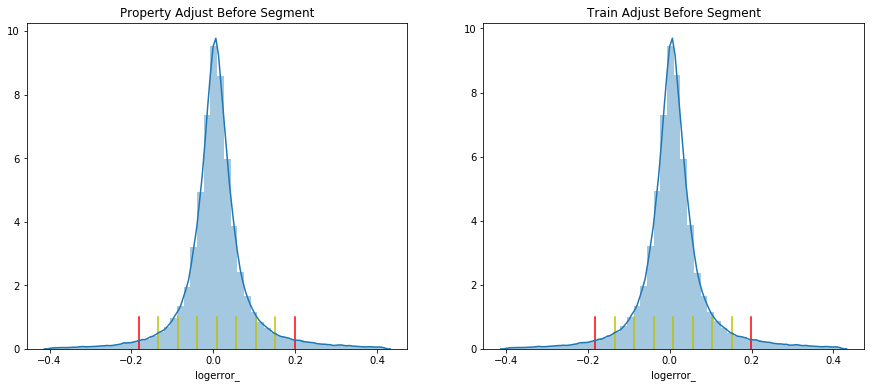

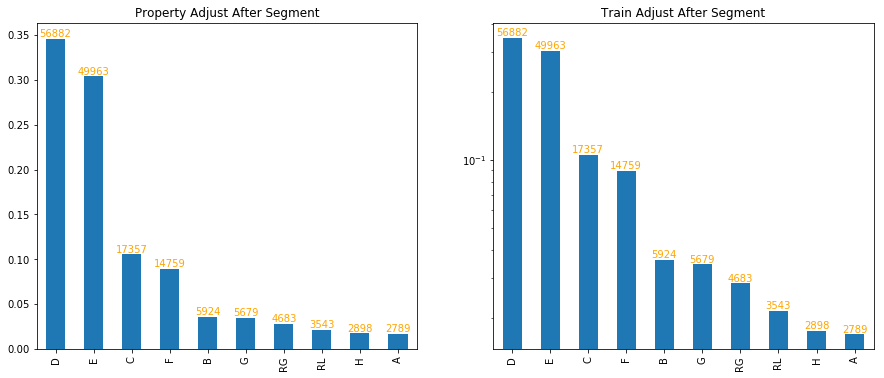

In [55]:
temp=properties.copy().set_index(['parcelid'])
temp['index_']=properties.index
location_train_idx=temp.loc[train_properties_clean.parcelid]['index_']
location_train_num=location_num[location_train_idx].copy()
location_train_cat=location_cat[location_train_idx].copy()
location_train_tgt=train_properties_clean[['parcelid']].copy()
location_train_tgt['logerror_']=train_properties_clean['logerror']
seg_process(location_train_tgt,'logerror_',n_seg=8)
location_train_tgtcat=preprocess_pipeline['logerror_'](location_train_tgt['logerror_'])
location_train_x=np.concatenate([location_train_cat,location_train_num],1)
location_train_y=preprocessing.LabelEncoder().fit_transform(location_train_tgtcat.values)
location_train_x=location_train_x.astype('float32')
model=discriminant_analysis.LinearDiscriminantAnalysis(n_components=3).fit(location_train_x,location_train_y)
location_x_lda=pd.DataFrame(model.transform(location_x)[:,:3],columns=['clusterlocation_lda_0','clusterlocation_lda_1','clusterlocation_lda_2'])
location_x_lda['parcelid']=properties.parcelid
del temp,model

In [56]:
properties=pd.merge(properties,location_x_lda,on='parcelid')

In [57]:
clustering(mixture.GaussianMixture(n_components=8),location_x,'clusterlocation_gm')

In [58]:
clustering(cluster.KMeans(n_clusters=8),location_x,'clusterlocation_km')

In [59]:
geo_cat=['clusterlocation_gm','clusterlocation_km']
geo_num=['clusterlocation_pca_0','clusterlocation_pca_1','clusterlocation_lda_0','clusterlocation_lda_1','clusterlocation_lda_2']

In [60]:
savecsv('geo',properties,cat=category_features+segment_features+special_cat+geo_cat,num=numerical_features+special_num+geo_num,lognum=numerical_features)

In [61]:
del location_x_lda,location_train_x,location_train_y,location_cat,location_num,location_train_cat,location_train_num,location_train_idx,location_train_tgt,location_train_tgtcat,location_x,location_x_pca

10. Impute Missing Data By ML Models
---------------------------------------------

In [62]:
for c in category_features+segment_features+special_cat+geo_cat:
    if c not in features2impute_ml:
        properties[c]=preprocessing.LabelEncoder().fit_transform(properties[c])

In [63]:
for c in numerical_features+special_num+geo_num:
    properties[c] = properties[c].astype(np.float32)

In [64]:
complete_features=category_features+segment_features+special_cat+geo_cat+numerical_features+special_num+geo_num
for c in features2impute_ml:
    complete_features.remove(c)
imputetrainsets=properties[complete_features].copy()

In [65]:
for f in features2impute_ml:
    print(f)
    train_x=imputetrainsets[properties[f].notnull()]
    train_y=properties[f][properties[f].notnull()]
    impute_x=imputetrainsets[properties[f].isnull()]
    model = ensemble.RandomForestClassifier()
    model.fit(train_x,train_y)
    print('ok')
    scores=model.score(train_x,train_y)
    print('R2 Score : '+str(scores.mean()))
    properties.at[properties[f].isnull(),f]=model.predict(impute_x)

buildingqualitytypeid
ok
R2 Score : 0.989079501022
heatingorsystemtypeid
ok
R2 Score : 0.993723353907
unitcnt
ok
R2 Score : 0.999039050703


{4.0: 'A', 5.0: 'E', 6.0: 'C', 7.0: 'B', 8.0: 'D', 9.0: 'F', 'N': 'N'}
{24.0: 'C', 2.0: 'A', 7.0: 'B', 'N': 'N'}


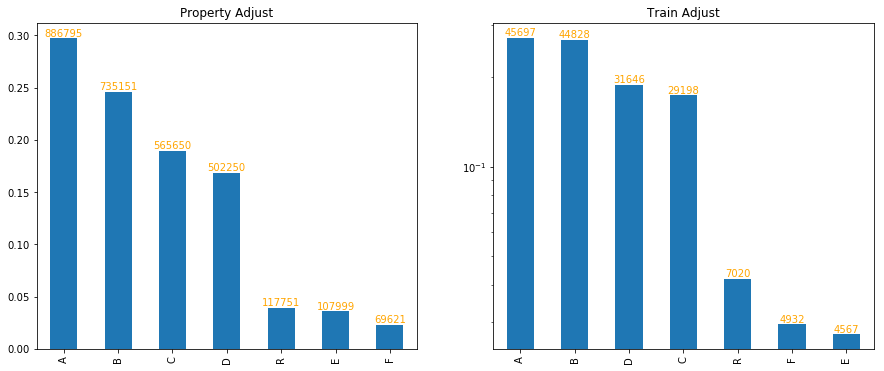

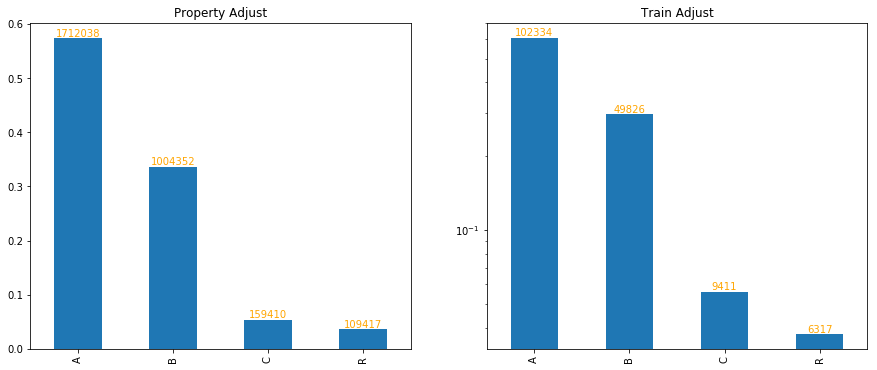

In [66]:
for c in features2impute_ml:
    if c in category_features:
        properties[c].astype('int64')
        cat_process(properties,c)
        properties[c]==preprocess_pipeline[c](properties[c])
        properties[c]=preprocessing.LabelEncoder().fit_transform(properties[c])
    else:
        properties[c]=properties[c].astype('float32')

In [67]:
savecsv('impute',properties,cat=category_features+segment_features+special_cat+geo_cat,num=numerical_features+special_num+geo_num,lognum=numerical_features)

In [68]:
del train_x,train_y,imputetrainsets,impute_x

11. Create New Features
-----------------------------

In [69]:
feature_corr=properties[numerical_features+special_num].corr()

In [70]:
feature_corr_rank=abs(feature_corr).mean(0).sort_values().index.values.tolist()

In [71]:
selected_feature=numerical_features+special_num
unselected_feature=geo_num
for i in range(len(feature_corr.values)):
    for j in range(len(feature_corr.values)):
        cr=feature_corr.values[i,j]
        if abs(cr)>0.3:
            if feature_corr_rank.index(feature_corr.index.values[i])<feature_corr_rank.index(feature_corr.index.values[j]):
                if feature_corr.index[j] in selected_feature:
                    selected_feature.remove(feature_corr.index[j])
                    unselected_feature.append(feature_corr.index[j])

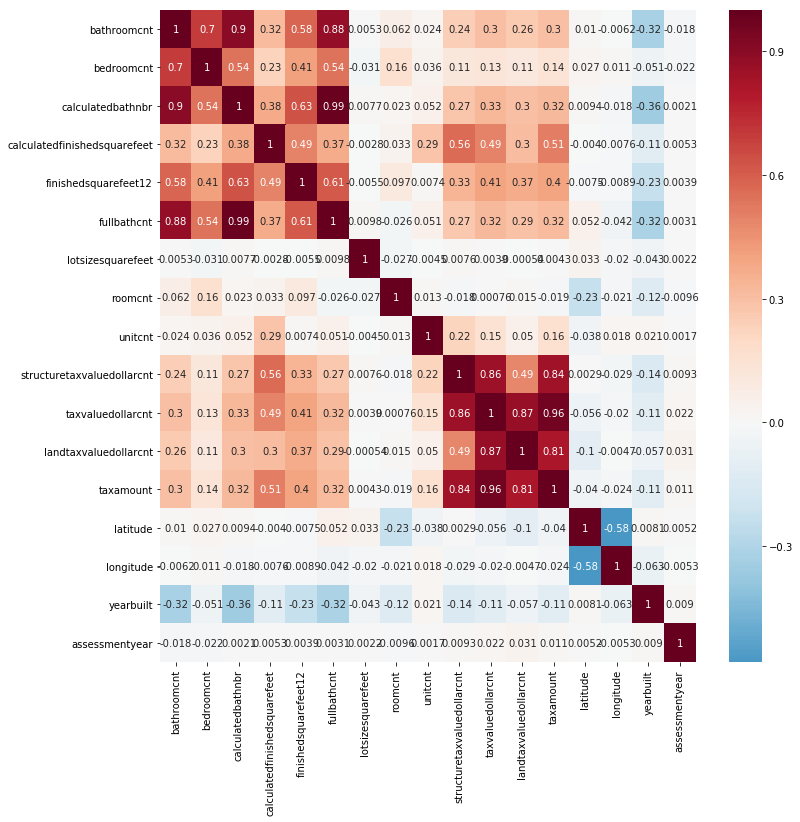

In [72]:
plt.figure(figsize=(12,12))
sns.heatmap(feature_corr,annot=True,cmap="RdBu_r",center=0)

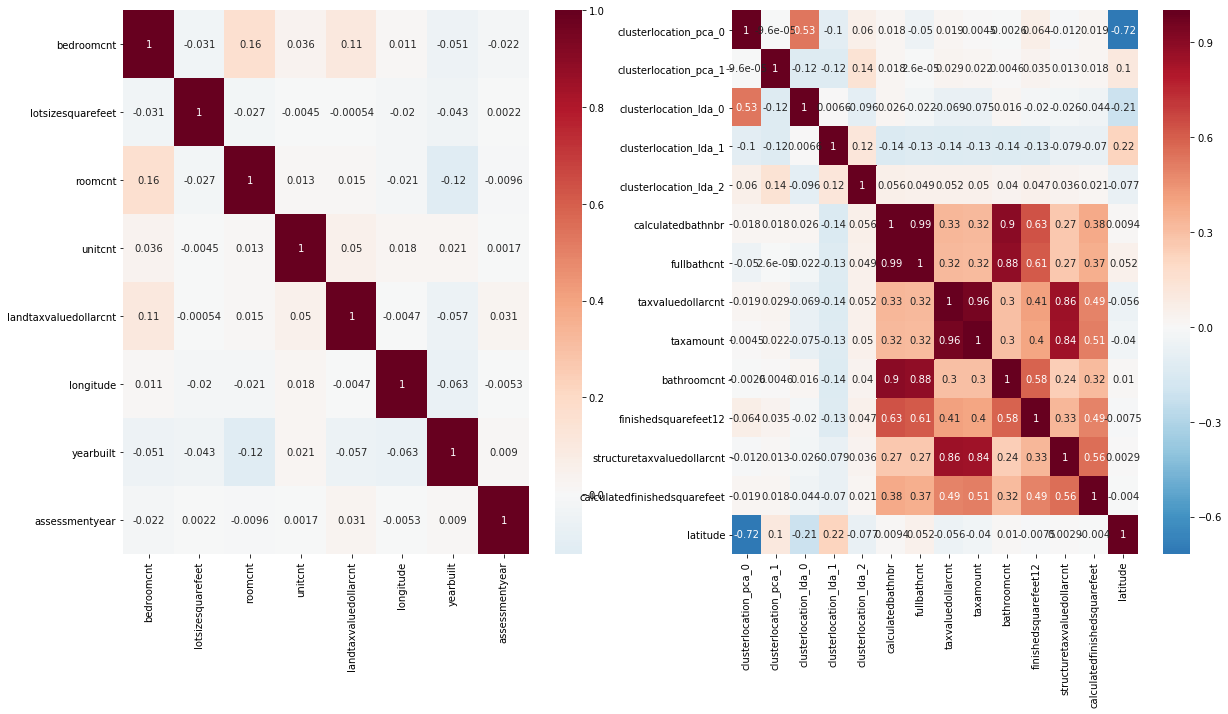

In [73]:
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.heatmap(properties[selected_feature].corr(),annot=True,cmap="RdBu_r",center=0)
plt.subplot(122)
sns.heatmap(properties[unselected_feature].corr(),annot=True,cmap="RdBu_r",center=0)

In [74]:
pstd=pd.DataFrame(properties.values.std(0),columns=['STD'],index=properties.columns)
fpstd=pstd[pstd.STD<0.3]
fpstd

,STD
architecturalstyletypeid,0.181121
basementsqft,0.064696
buildingclasstypeid,0.164583
decktypeid,0.106724
finishedsquarefeet13,0.127907
finishedsquarefeet6,0.253109
hashottuborspa,0.194860
poolsizesum,0.276160
pooltypeid10,0.132988
pooltypeid2,0.145749


In [84]:
pstd[pstd.STD>=0.3].loc[selected_feature]

,STD
bedroomcnt,1.270948
lotsizesquarefeet,241257.994408
roomcnt,2.838842
unitcnt,2.345390
landtaxvaluedollarcnt,485459.472006
longitude,345423.195963
yearbuilt,23.648868
assessmentyear,NaN


In [75]:
lpstd=fpstd.columns.values.tolist()
for f in copy.copy(selected_feature):
    if f in lpstd:
        selected_feature.remove(f)
        unselected_feature.append(f)

In [76]:
pf=preprocessing.PolynomialFeatures(degree=3,interaction_only=True)
poly_result=pf.fit_transform(preprocessing.StandardScaler().fit_transform(properties[selected_feature]))

In [77]:
pfnames=pf.get_feature_names()[(len(selected_feature)+1):]
for i,names in enumerate(pfnames):
    name=''
    for n in names.split(' '):
        name+=selected_feature[int(n[1:])]+'*'
    pfnames[i]=name[:-1]

In [78]:
poly_result=pd.DataFrame(poly_result[:,(len(selected_feature)+1):],columns=pfnames)

In [79]:
properties=pd.concat([properties,poly_result],axis=1)

In [81]:
savecsv('poly',properties,cat=category_features+segment_features+special_cat+geo_cat,num=numerical_features+special_num+geo_num+pfnames,lognum=numerical_features)

In [86]:
poly_result.head()

,bedroomcnt*lotsizesquarefeet,bedroomcnt*roomcnt,bedroomcnt*unitcnt,bedroomcnt*landtaxvaluedollarcnt,bedroomcnt*longitude,bedroomcnt*yearbuilt,bedroomcnt*assessmentyear,lotsizesquarefeet*roomcnt,lotsizesquarefeet*unitcnt,lotsizesquarefeet*landtaxvaluedollarcnt,...,unitcnt*landtaxvaluedollarcnt*longitude,unitcnt*landtaxvaluedollarcnt*yearbuilt,unitcnt*landtaxvaluedollarcnt*assessmentyear,unitcnt*longitude*yearbuilt,unitcnt*longitude*assessmentyear,unitcnt*yearbuilt*assessmentyear,landtaxvaluedollarcnt*longitude*yearbuilt,landtaxvaluedollarcnt*longitude*assessmentyear,landtaxvaluedollarcnt*yearbuilt*assessmentyear,longitude*yearbuilt*assessmentyear
0,-0.635750,1.262764,0.220173,1.343013,3.187905,-0.965157,0.071276,-0.135528,-0.023630,-0.144141,...,-0.065385,0.019796,-0.001462,0.046989,-0.003470,0.001051,0.286624,-0.021167,0.006408,0.015212
1,0.188295,1.262764,0.220173,1.205108,2.985546,-0.965157,-40.242203,0.040140,0.006999,0.038308,...,-0.054947,0.017763,0.740630,0.044006,1.834844,-0.593162,0.240867,10.042946,-3.246648,-8.043274
2,-0.406922,1.262764,-0.817535,-2.538664,1.359851,-0.553496,0.071276,-0.086747,0.056161,0.174396,...,-0.195764,0.079681,-0.010261,-0.042682,0.005496,-0.002237,-0.132538,0.017068,-0.006947,0.003721
3,0.153612,1.262764,0.220173,-1.637020,1.659839,-1.685563,0.071276,0.032747,0.005710,-0.042452,...,0.041497,-0.042140,0.001782,0.042727,-0.001807,0.001835,-0.317683,0.013434,-0.013642,0.013832
4,0.143615,1.262764,0.220173,0.123034,1.297734,-1.788479,0.071276,0.030616,0.005338,0.002983,...,-0.002438,0.003360,-0.000134,0.035446,-0.001413,0.001947,0.019807,-0.000789,0.001088,0.011475


In [88]:
properties[geo_cat+geo_num].head()

,clusterlocation_gm,clusterlocation_km,clusterlocation_pca_0,clusterlocation_pca_1,clusterlocation_lda_0,clusterlocation_lda_1,clusterlocation_lda_2,calculatedbathnbr,fullbathcnt,taxvaluedollarcnt,taxamount,bathroomcnt,finishedsquarefeet12,structuretaxvaluedollarcnt,calculatedfinishedsquarefeet,latitude
0,2,0,-1.491442,-0.419062,-0.769558,-1.539107,-0.144894,2.0,2.0,9.0,4006.969971,0.0,1541.0,126984.0,1574.0,34144440.0
1,2,0,-1.244500,-0.660533,-1.959872,-2.094678,-2.046088,2.0,2.0,27516.0,4006.969971,0.0,1541.0,126984.0,1574.0,34140432.0
2,2,0,-0.092577,-1.549153,-2.182284,-1.900786,-1.366373,2.0,2.0,1434941.0,20800.369141,0.0,1541.0,660680.0,73026.0,33989360.0
3,7,2,-1.750904,-0.076296,-0.707939,-1.541850,0.003476,2.0,2.0,1174475.0,14557.570312,0.0,1541.0,580059.0,5068.0,34148864.0
4,7,2,-1.889111,0.485813,-0.202815,-1.114117,-0.393501,2.0,2.0,440101.0,5725.169922,0.0,1541.0,196751.0,1776.0,34194168.0
